# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

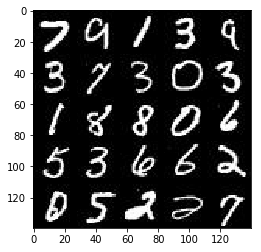

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [3]:
mnist_images[0].shape

(28, 28, 1)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

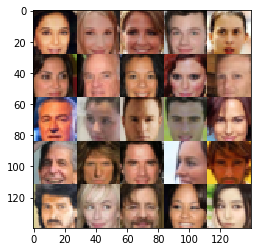

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # now is 16x16x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # now is 8x8x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # now is 4x4x256
        
        # flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # training and reuse are opposite
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # first, fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)        
        # reshape it to start conv 
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # now 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # now 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # now 28x28x128
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # now 28x28x32
        
        
        # output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # now 28x28x3
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                               labels = tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                               labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                               labels = tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # get variable
    t_var = tf.trainable_variables()
    d_var = [var for var in t_var if var.name.startswith('discriminator')]
    g_var = [var for var in t_var if var.name.startswith('generator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 20
    show_every = 100
    
    
    # set up optimizer
    print(data_shape)
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
                
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizer
                sess.run(d_opt, feed_dict={input_z: batch_z, 
                                           input_real: batch_images, 
                                           learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, 
                                           input_real: batch_images, 
                                           learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, 
                                           input_real: batch_images, 
                                           learn_rate: learning_rate})
                
                # print info
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # show image           
                if steps % show_every == 0:                    
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 1.5817
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 2.8529
Epoch 1/2... Discriminator Loss: 1.9400... Generator Loss: 0.4000
Epoch 1/2... Discriminator Loss: 1.6460... Generator Loss: 0.7647
Epoch 1/2... Discriminator Loss: 2.0281... Generator Loss: 0.2926


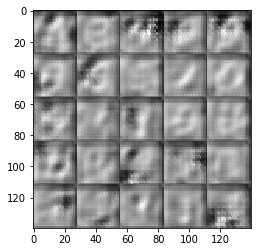

Epoch 1/2... Discriminator Loss: 1.5320... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 1.4437... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.9327
Epoch 1/2... Discriminator Loss: 1.5168... Generator Loss: 0.7455
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.7108


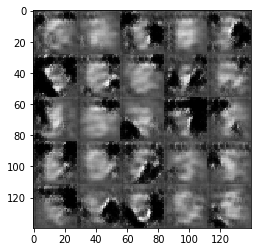

Epoch 1/2... Discriminator Loss: 1.8312... Generator Loss: 0.6606
Epoch 1/2... Discriminator Loss: 1.6148... Generator Loss: 0.5513
Epoch 1/2... Discriminator Loss: 1.5376... Generator Loss: 0.5243
Epoch 1/2... Discriminator Loss: 1.5918... Generator Loss: 0.4229
Epoch 1/2... Discriminator Loss: 1.7944... Generator Loss: 0.3979


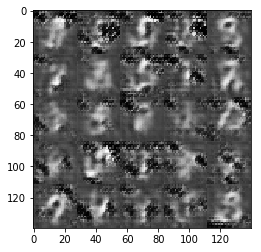

Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 1.4729... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.7308... Generator Loss: 0.6895
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.5789


Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.7551
Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.8269
Epoch 1/2... Discriminator Loss: 1.5664... Generator Loss: 0.6571


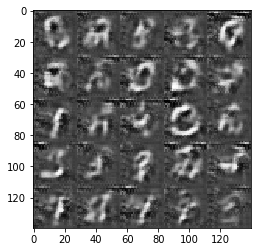

Epoch 1/2... Discriminator Loss: 1.4906... Generator Loss: 0.5645
Epoch 1/2... Discriminator Loss: 1.5654... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.6603


Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.6687
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 1.6482... Generator Loss: 0.5746


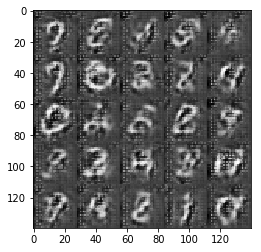

Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.7389


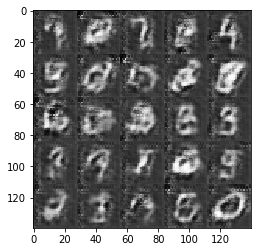

Epoch 1/2... Discriminator Loss: 1.4773... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.4540... Generator Loss: 0.7331


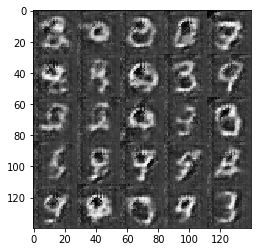

Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.7262
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 0.6099


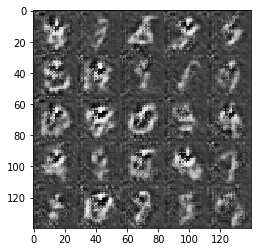

Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.4879... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.6634


Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 1.5093... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.7499


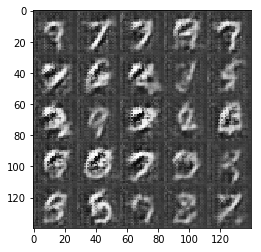

Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.7197


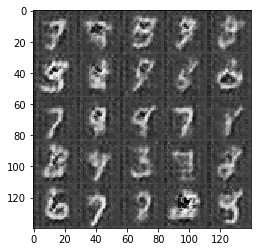

Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 0.7312
Epoch 1/2... Discriminator Loss: 1.4699... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 0.7332


Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.7813


Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.4480... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.3958... Generator Loss: 0.7697
Epoch 1/2... Discriminator Loss: 1.5302... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.7060


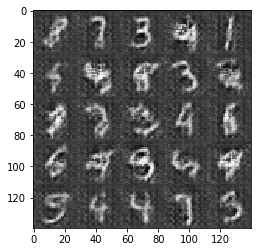

Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.5143... Generator Loss: 0.5735
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.7737


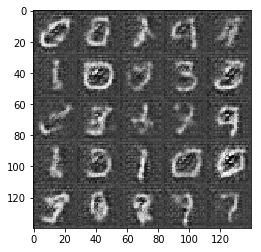

Epoch 1/2... Discriminator Loss: 1.4917... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.4658... Generator Loss: 0.7045


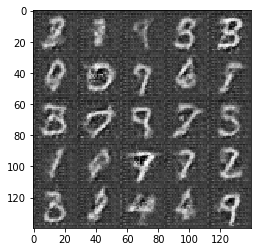

Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.7153
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 1.4619... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.7333


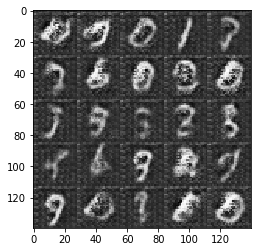

Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.7594
Epoch 2/2... Discriminator Loss: 1.4371... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.4250... Generator Loss: 0.7430


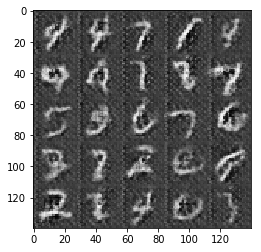

Epoch 2/2... Discriminator Loss: 1.4597... Generator Loss: 0.6847
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.7213
Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.7479
Epoch 2/2... Discriminator Loss: 1.4182... Generator Loss: 0.7114


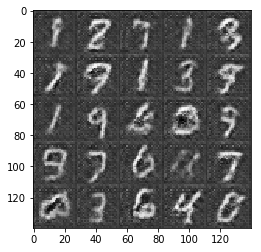

Epoch 2/2... Discriminator Loss: 1.4738... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.4944... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 1.4446... Generator Loss: 0.7073
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.7457
Epoch 2/2... Discriminator Loss: 1.5075... Generator Loss: 0.6375


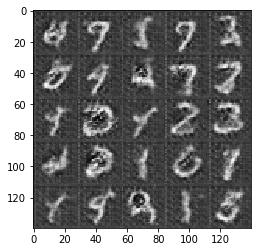

Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.4459... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.4665... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 0.6782


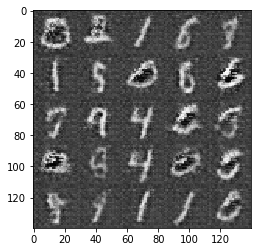

Epoch 2/2... Discriminator Loss: 1.4605... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 1.4849... Generator Loss: 0.6385
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.4891... Generator Loss: 0.6531


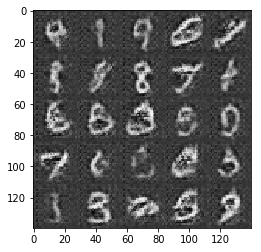

Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.4777... Generator Loss: 0.6589
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.6687


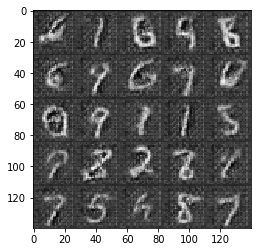

Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 1.4891... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.4497... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.4792... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.7122


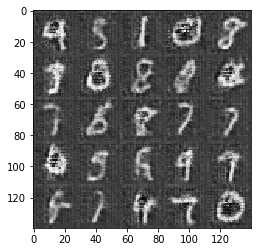

Epoch 2/2... Discriminator Loss: 1.4500... Generator Loss: 0.7814
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 1.4790... Generator Loss: 0.5054
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.7818
Epoch 2/2... Discriminator Loss: 1.5164... Generator Loss: 0.6515


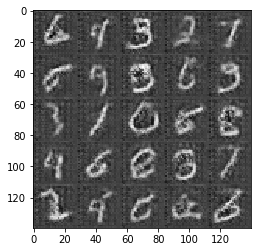

Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.6407
Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.4321... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.7413


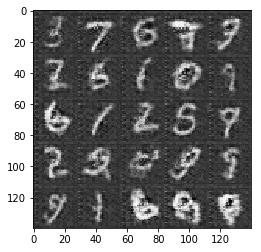

Epoch 2/2... Discriminator Loss: 1.4945... Generator Loss: 0.6570
Epoch 2/2... Discriminator Loss: 1.4046... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.7482
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.7368


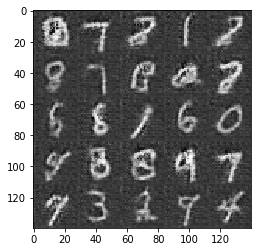

Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.6886
Epoch 2/2... Discriminator Loss: 1.4071... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.4693... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.4572... Generator Loss: 0.7151


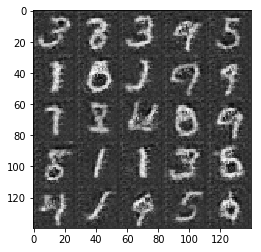

Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.4798... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.4561... Generator Loss: 0.7060
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.7415
Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.7857


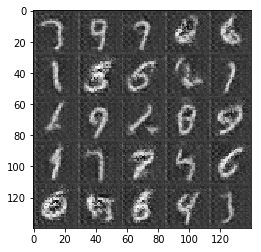

Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 0.7321
Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.4446... Generator Loss: 0.7153


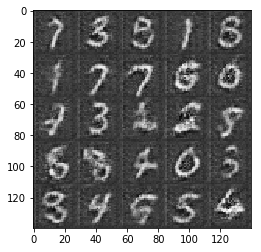

Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.8410
Epoch 2/2... Discriminator Loss: 1.4639... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 0.6901
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.7942
Epoch 2/2... Discriminator Loss: 1.4202... Generator Loss: 0.6814


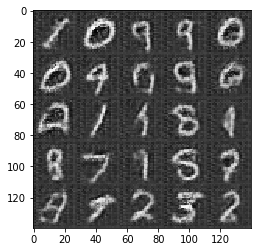

Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.4221... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.7597
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.7241


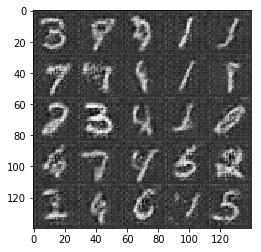

Epoch 2/2... Discriminator Loss: 1.4366... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.7494
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 1.4394... Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 0.7633


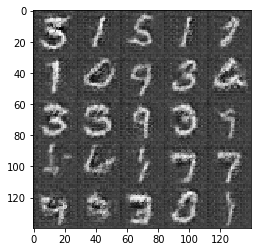

Epoch 2/2... Discriminator Loss: 1.4535... Generator Loss: 0.7154
Epoch 2/2... Discriminator Loss: 1.4697... Generator Loss: 0.6434
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.8715


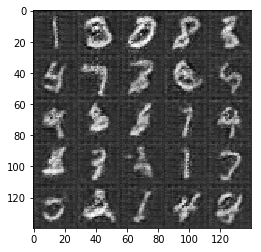

Epoch 2/2... Discriminator Loss: 1.4112... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.4681... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 1.4393... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 0.7213


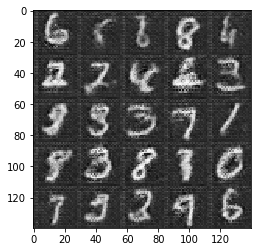

Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 0.6814


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 2.3763... Generator Loss: 0.1458
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 2.2585
Epoch 1/1... Discriminator Loss: 2.7593... Generator Loss: 0.1219
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.8961


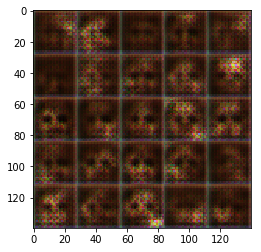

Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.3955
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.5492


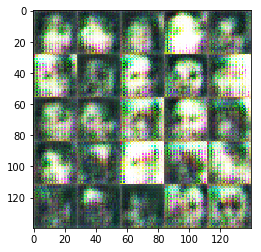

Epoch 1/1... Discriminator Loss: 1.6181... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.7362... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 2.3094
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.4761


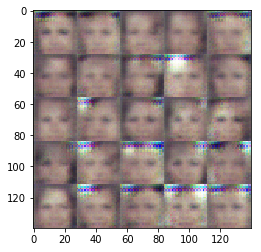

Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 2.7329
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.8567
Epoch 1/1... Discriminator Loss: 2.1623... Generator Loss: 0.2869
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.8224... Generator Loss: 0.3612


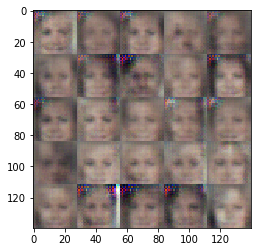

Epoch 1/1... Discriminator Loss: 1.7209... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.6740... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6617


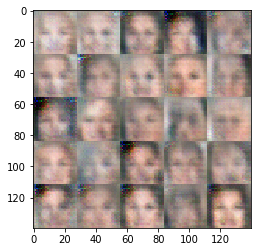

Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.7846
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.7026... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.7437


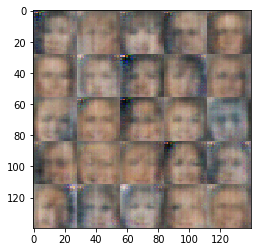

Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.6416... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 2.2108
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 1.1265


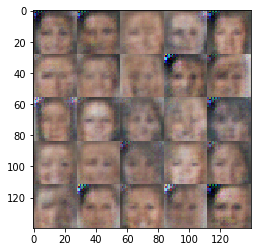

Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 1.5065


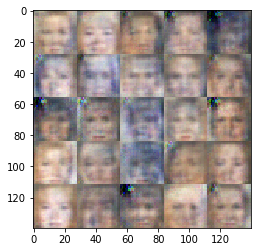

Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.5744


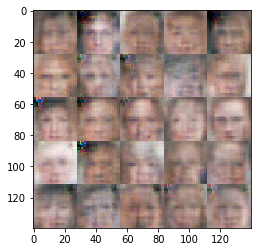

Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 1.0198


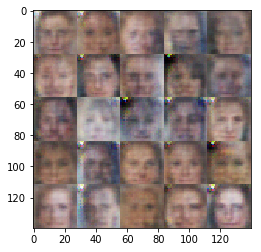

Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.2493


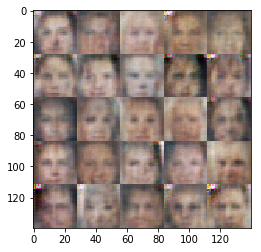

Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.6372... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 2.0994


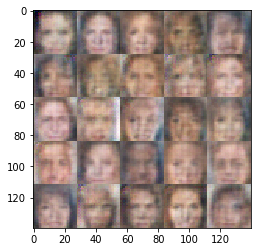

Epoch 1/1... Discriminator Loss: 1.6839... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 2.0996
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.7869


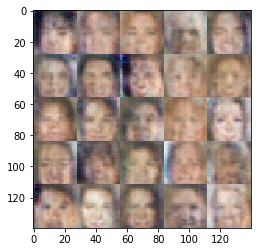

Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.5386


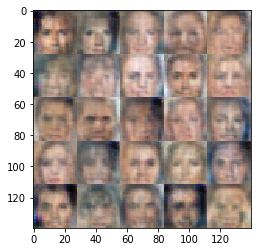

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.9757


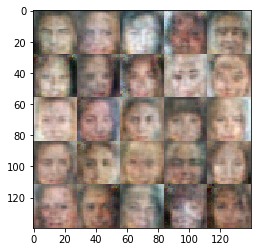

Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 1.3414


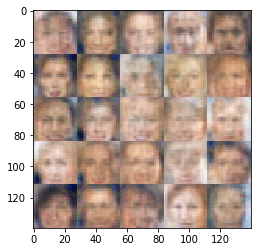

Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.7360


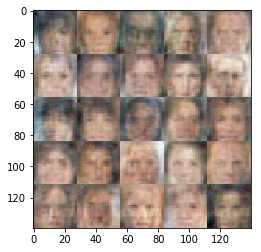

Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.5659
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.9461


Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 2.7990
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5755


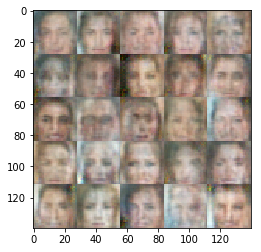

Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.8498


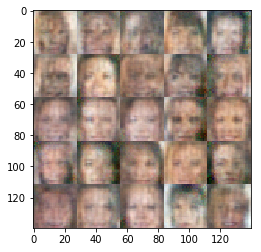

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.7239


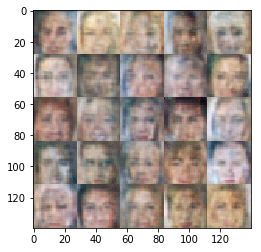

Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.6363
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.6064


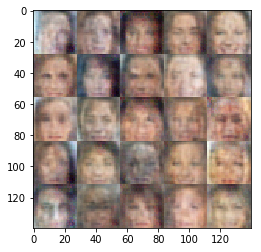

Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.3579
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.8099
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.9917


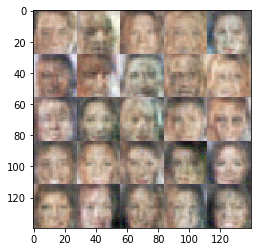

Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.9139... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.3643
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.7136


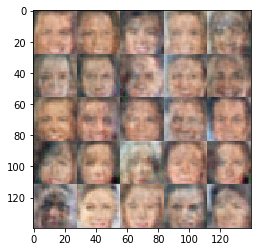

Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.7909


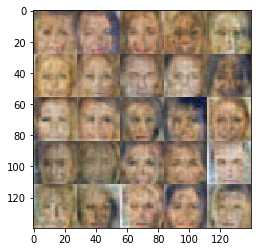

Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 2.1997
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.6203
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.8027


Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6734


Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.0873


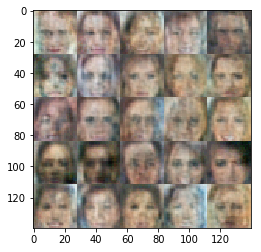

Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.5758


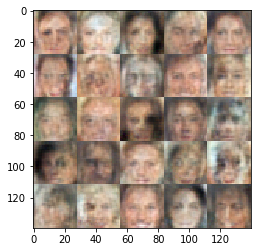

Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.5476
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8026


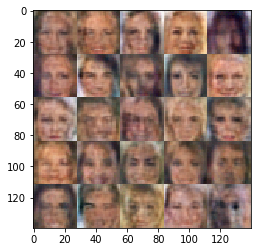

Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.6798


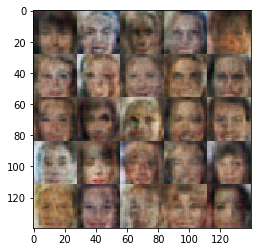

Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.6887


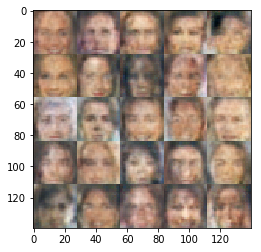

Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7208


Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.7172


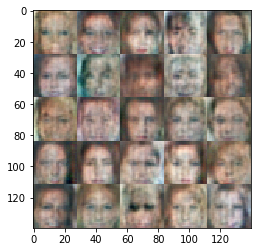

Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7307


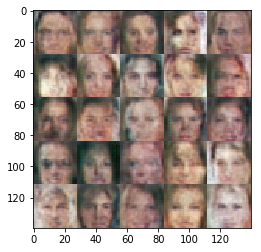

Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7087


Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7297


Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7053


Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7714


Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7238


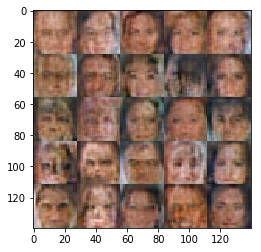

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.6999


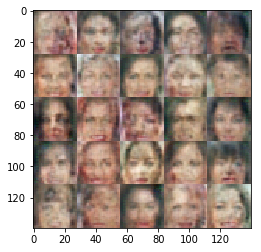

Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8766


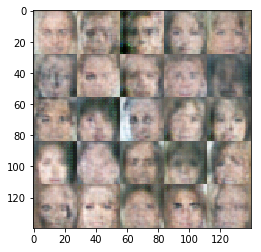

Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.4169


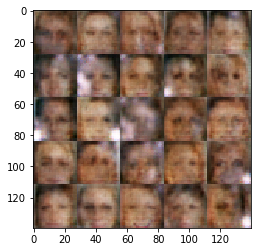

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.7179
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.5901


Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7106


Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.7166


Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7139


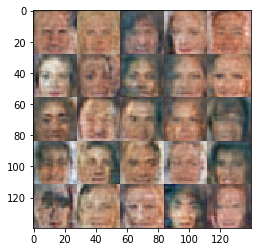

Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7658


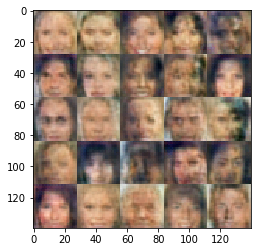

Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7645


Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7399


Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7445


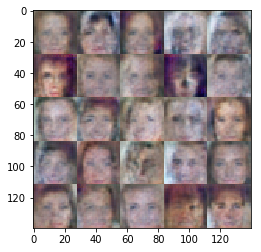

Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7198


Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7220


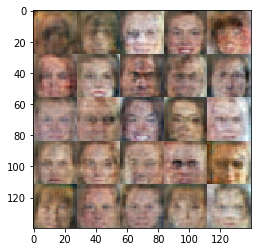

Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7078


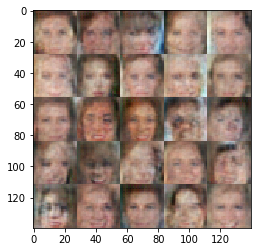

Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7340


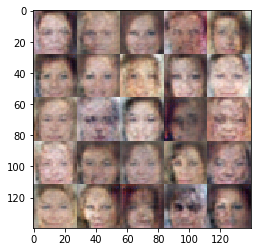

Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7300


Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7933


Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7692


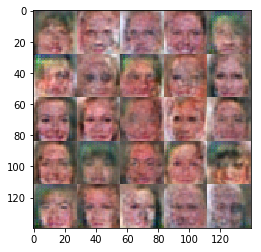

Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7775


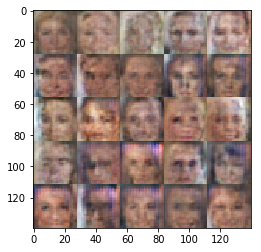

Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7436


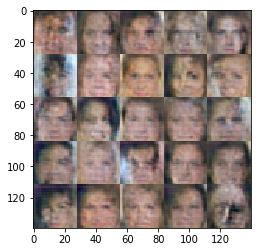

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.8394


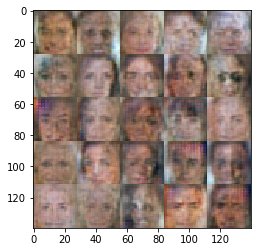

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7898


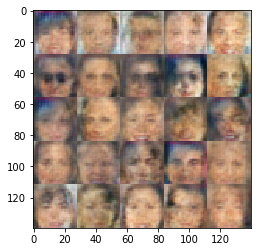

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.8168


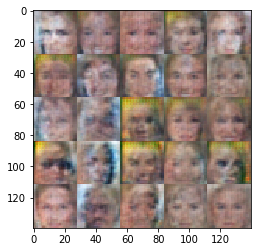

Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8042


In [15]:
batch_size = 32
z_dim = 200
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.